#  🤗 Transformers Finetuning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://huggingface.co/docs/transformers/training
* https://huggingface.co/docs/datasets/main/en/repository_structure
* https://huggingface.co/docs/datasets/main/en/package_reference/loading_methods#datasets.load_dataset
* https://huggingface.co/docs/transformers/v4.35.2/en/training#prepare-a-dataset
* https://huggingface.co/docs/datasets/v2.0.0/en/image_process
* https://huggingface.co/docs/datasets/v3.0.1/en/package_reference/main_classes#datasets.Dataset.train_test_split
* https://huggingface.co/docs/datasets/process
* https://huggingface.co/docs/evaluate/index
* https://huggingface.co/docs/transformers/main_classes/trainer
* https://huggingface.co/docs/transformers/v4.35.2/en/main_classes/trainer#transformers.TrainingArguments
* https://albumentations.ai/docs/getting_started/image_augmentation/
* https://wandb.ai/ayush-thakur/huggingface/reports/Examples-of-Early-Stopping-in-HuggingFace-Transformers--Vmlldzo0MzE2MTM
* https://colab.research.google.com/github/wandb/examples/blob/master/colabs/huggingface/Optimize_Hugging_Face_models_with_Weights_&_Biases.ipynb#scrollTo=8k0XaprCT51P

## Задачи для совместного разбора

1\. Обсудите основные шаги по дообучению моделей из экосистемы 🤗 Transformers.

## Задачи для самостоятельного решения

<p class='task' id='1'></p>

1\. Создайте набор данных для обучения модели классификации пород кошек, используя пакет 🤗 Datasets. Разделите датасет на обучающее и тестовое множество в соотношении 80/20. 

К обучающему множеству примените следующие преобразования из пакета `albumentations`:
- Resize до 256х256;
- CenterCrop до размера 224х224;
- минимум одно преобразование, случайным образом изменяющее изображение.

К тестовому множеству примените аналогичное преобразование, но без добавления случайных изменений.

Создайте два `DataLoader` на основе обучающего и валидационного множества. Получите батч из обучающего множества и форму признаков и меток на экран. Признаки в батче должны быть уложены в четырехмерный тензор.

- [ ] Проверено на семинаре

In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import albumentations as A
import numpy as np

In [2]:
dataset_path = './../data/cat_breeds_4'
dataset = ImageFolder(dataset_path)
dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])

In [3]:
al_train = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.RandomRotate90(),
])

al_test = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
])

In [4]:
class AlbumentationsTransform:
    def __init__(self, augmentations):
        self.augment = augmentations

    def __call__(self, img):
        img = np.array(img)
        augmented = self.augment(image=img)
        img = augmented['image']
        return img

In [5]:
dataset_train.dataset.transform = AlbumentationsTransform(al_train)
dataset_test.dataset.transform = AlbumentationsTransform(al_test)

In [6]:
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False)

In [7]:
train_features, train_labels = next(iter(train_loader))
print(f'Форма признаков: {train_features.shape}')
print(f'Форма меток: {train_labels.shape}')

Форма признаков: torch.Size([16, 224, 224, 3])
Форма меток: torch.Size([16])


<p class='task' id='2'></p>

2\. Создайте модель при помощи класса `AutoModelForImageClassification`, заменив голову модели в соответствии с решаемой задачей  классификации. Используя стандартный цикл обучения `torch` (или `pytorch_lightning`), настройте модель. Во время обучения выводите на экран значение функции потерь и значение F1 на обучающем множестве, а также F1 на валидационном множестве. 

- [ ] Проверено на семинаре

In [8]:
import torch as th
from transformers import AutoModelForImageClassification

device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = AutoModelForImageClassification.from_pretrained(
    'google/efficientnet-b0', ignore_mismatched_sizes=True, num_labels=4
).to(device)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([4, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from torch import nn, optim
from torchmetrics import F1Score

epochs = 7
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

train_f1_metric = F1Score(task='multiclass', num_classes=4).to(device)
val_f1_metric = F1Score(task='multiclass', num_classes=4).to(device)

In [10]:
from tqdm import tqdm

for epoch in tqdm(range(epochs), desc='train'):
    model.train()
    running_loss = 0.0
    train_f1_metric.reset()
    
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2).float().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = th.argmax(outputs.logits, dim=1)
        train_f1_metric.update(preds, labels)
    train_f1 = train_f1_metric.compute().item()

    model.eval()
    val_f1_metric.reset()
    with th.no_grad():
        for images, labels in tqdm(test_loader, desc='val'):
            images = images.permute(0, 3, 1, 2).float().to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            preds = th.argmax(outputs.logits, dim=1)
            val_f1_metric.update(preds, labels)
    
    val_f1 = val_f1_metric.compute().item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Train F1: {train_f1}, Validation F1: {val_f1}')

train:  14%|█▍        | 1/7 [00:11<01:10, 11.79s/it]

Epoch 1/7, Loss: 0.9247250428795815, Train F1: 0.6706249713897705, Validation F1: 0.7787500023841858


train:  29%|██▊       | 2/7 [00:23<00:57, 11.49s/it]

Epoch 2/7, Loss: 0.5163190484046936, Train F1: 0.8081250190734863, Validation F1: 0.8237500190734863


train:  43%|████▎     | 3/7 [00:34<00:45, 11.39s/it]

Epoch 3/7, Loss: 0.39655361108481885, Train F1: 0.8506249785423279, Validation F1: 0.8424999713897705


train:  57%|█████▋    | 4/7 [00:45<00:34, 11.35s/it]

Epoch 4/7, Loss: 0.31956658769398927, Train F1: 0.8809375166893005, Validation F1: 0.8362500071525574


train:  71%|███████▏  | 5/7 [00:56<00:22, 11.29s/it]

Epoch 5/7, Loss: 0.24905757704749704, Train F1: 0.9128124713897705, Validation F1: 0.8299999833106995


train:  86%|████████▌ | 6/7 [01:08<00:11, 11.26s/it]

Epoch 6/7, Loss: 0.17580156615003945, Train F1: 0.9459375143051147, Validation F1: 0.8462499976158142


train: 100%|██████████| 7/7 [01:19<00:00, 11.30s/it]

Epoch 7/7, Loss: 0.1355725079262629, Train F1: 0.9568750262260437, Validation F1: 0.8162500262260437


<p class='task' id='3'></p>

3\. Создайте модель при помощи класса `AutoModelForImageClassification`, заменив голову модели в соответствии решаемой задачей  классификации. Используя `transformers.Trainer`, настройте модель для решения задачи. Во время обучения выводите на экран значение функции потерь на обучающем и валидационном множества, а также F1 на валидационном множестве. 

Настройте `Trainer` таким образом, чтобы логирование процесса обучения осуществлялось при помощи `wandb`. Прикрепите скриншоты интерфейса `wandb` с результатами. 

- [ ] Проверено на семинаре

In [ ]:
from transformers import TrainingArguments, Trainer
from torch.utils.data import Dataset
import evaluate
import wandb

In [11]:
wandb.login()
wandb.init(project='image-classification-project')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kekwak. Use `wandb login --relogin` to force relogin


In [ ]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained('google/efficientnet-b0')

In [48]:
from datasets import Dataset as HFDataset

def transform_dataset(dataset, processor):
    images = []
    labels = []
    for img, label in dataset:
        encoding = processor(img, return_tensors='pt')
        images.append(encoding['pixel_values'].squeeze())
        labels.append(label)
    return HFDataset.from_dict({'pixel_values': images, 'labels': labels})

train_dataset = transform_dataset(dataset_train, processor)
eval_dataset = transform_dataset(dataset_test, processor)

In [50]:
num_labels = len(dataset.classes)
label_names = dataset.classes
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

model = AutoModelForImageClassification.from_pretrained(
    'google/efficientnet-b0',
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([4, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)['accuracy']
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')['f1']
    return {'accuracy': accuracy, 'f1': f1}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=12,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_strategy='epoch',
    eval_strategy='epoch',
    logging_strategy='steps',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to='wandb',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [17]:
wandb.finish()

eval/accuracy,▁▆▆▆▇▆▆▆█▇▆▇
eval/f1,▁▆▆▆▇▇▆▆█▇▆▇
eval/loss,█▂▂▃▁▂▂▃▃▂▄▄
eval/runtime,▄█▆█▇▇▁▁▃▂▅▃
eval/samples_per_second,▅▁▃▁▂▂██▆▇▄▆
eval/steps_per_second,▅▁▃▁▂▂██▆▇▄▆
train/epoch,▁▁▁▁▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇███
train/grad_norm,▃▄▄▂▃▄▃▅▇▃▂▅▅▄▃▂▄▂▄▃▆▃▆▄▁▁▃▁▂▃▃▆▅▄▁▄▅█▂▃
train/learning_rate,███▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,███▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁


![Screenshot 2024-11-28 at 15.59.05.png](<attachment:Screenshot 2024-11-28 at 15.59.05.png>)
![Screenshot 2024-11-28 at 15.59.18.png](<attachment:Screenshot 2024-11-28 at 15.59.18.png>)
![Screenshot 2024-11-28 at 15.59.25.png](<attachment:Screenshot 2024-11-28 at 15.59.25.png>)
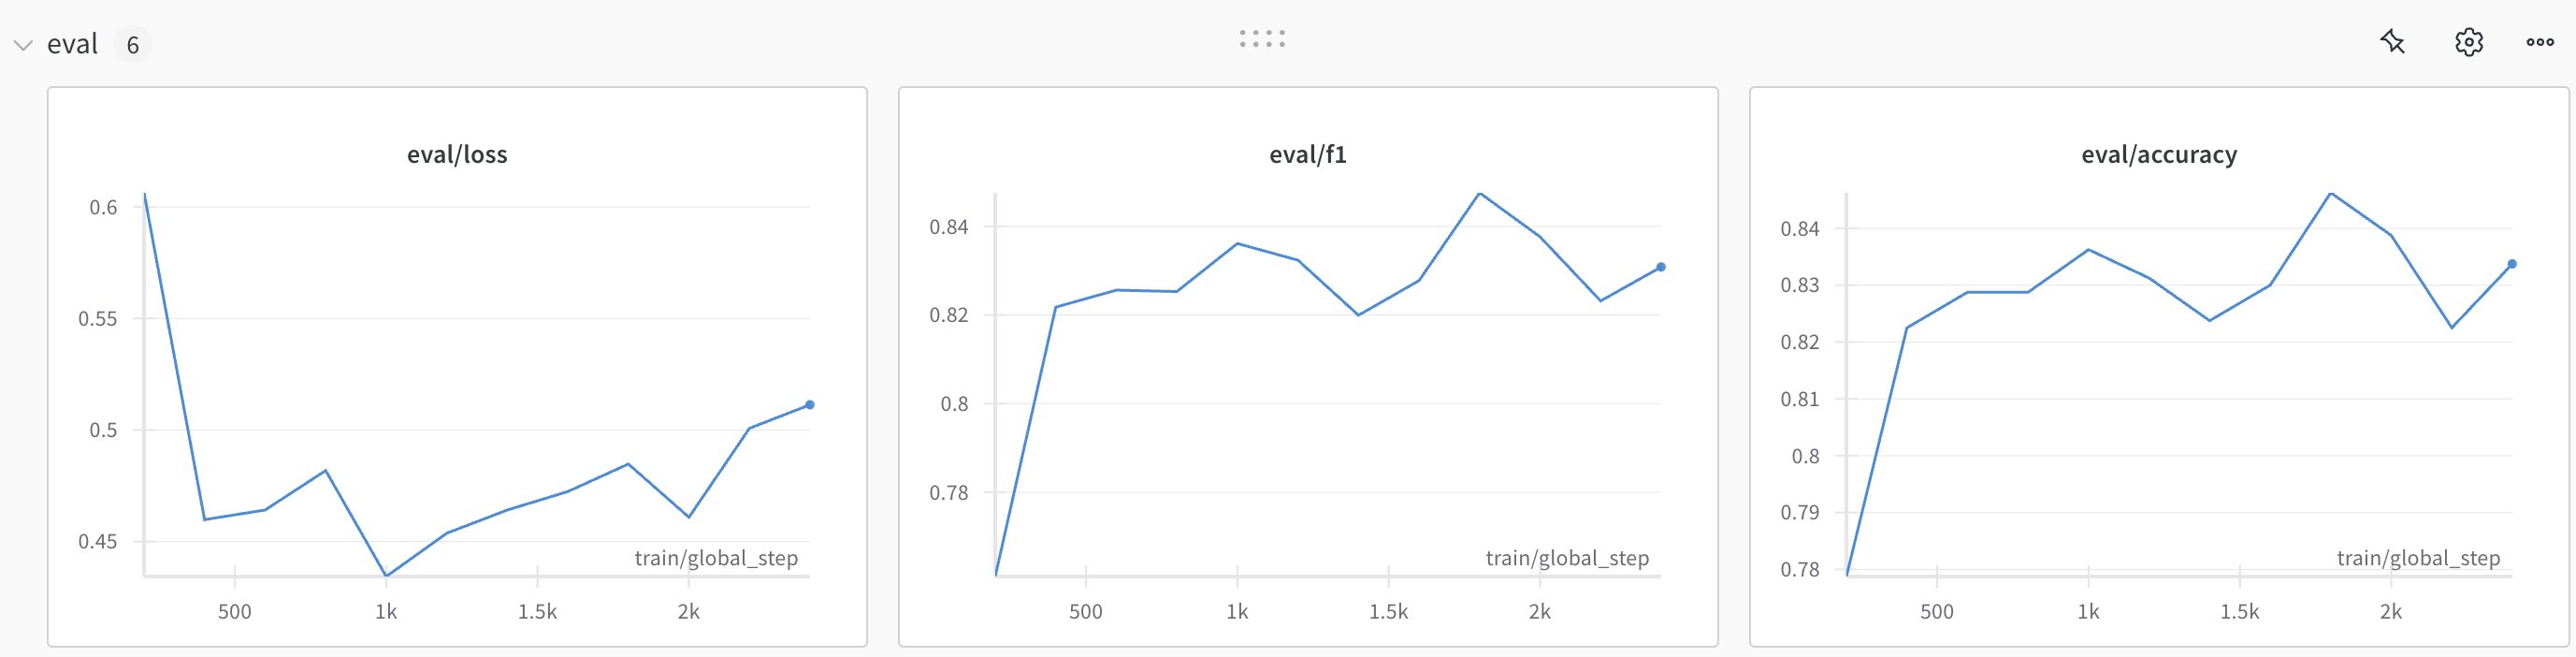
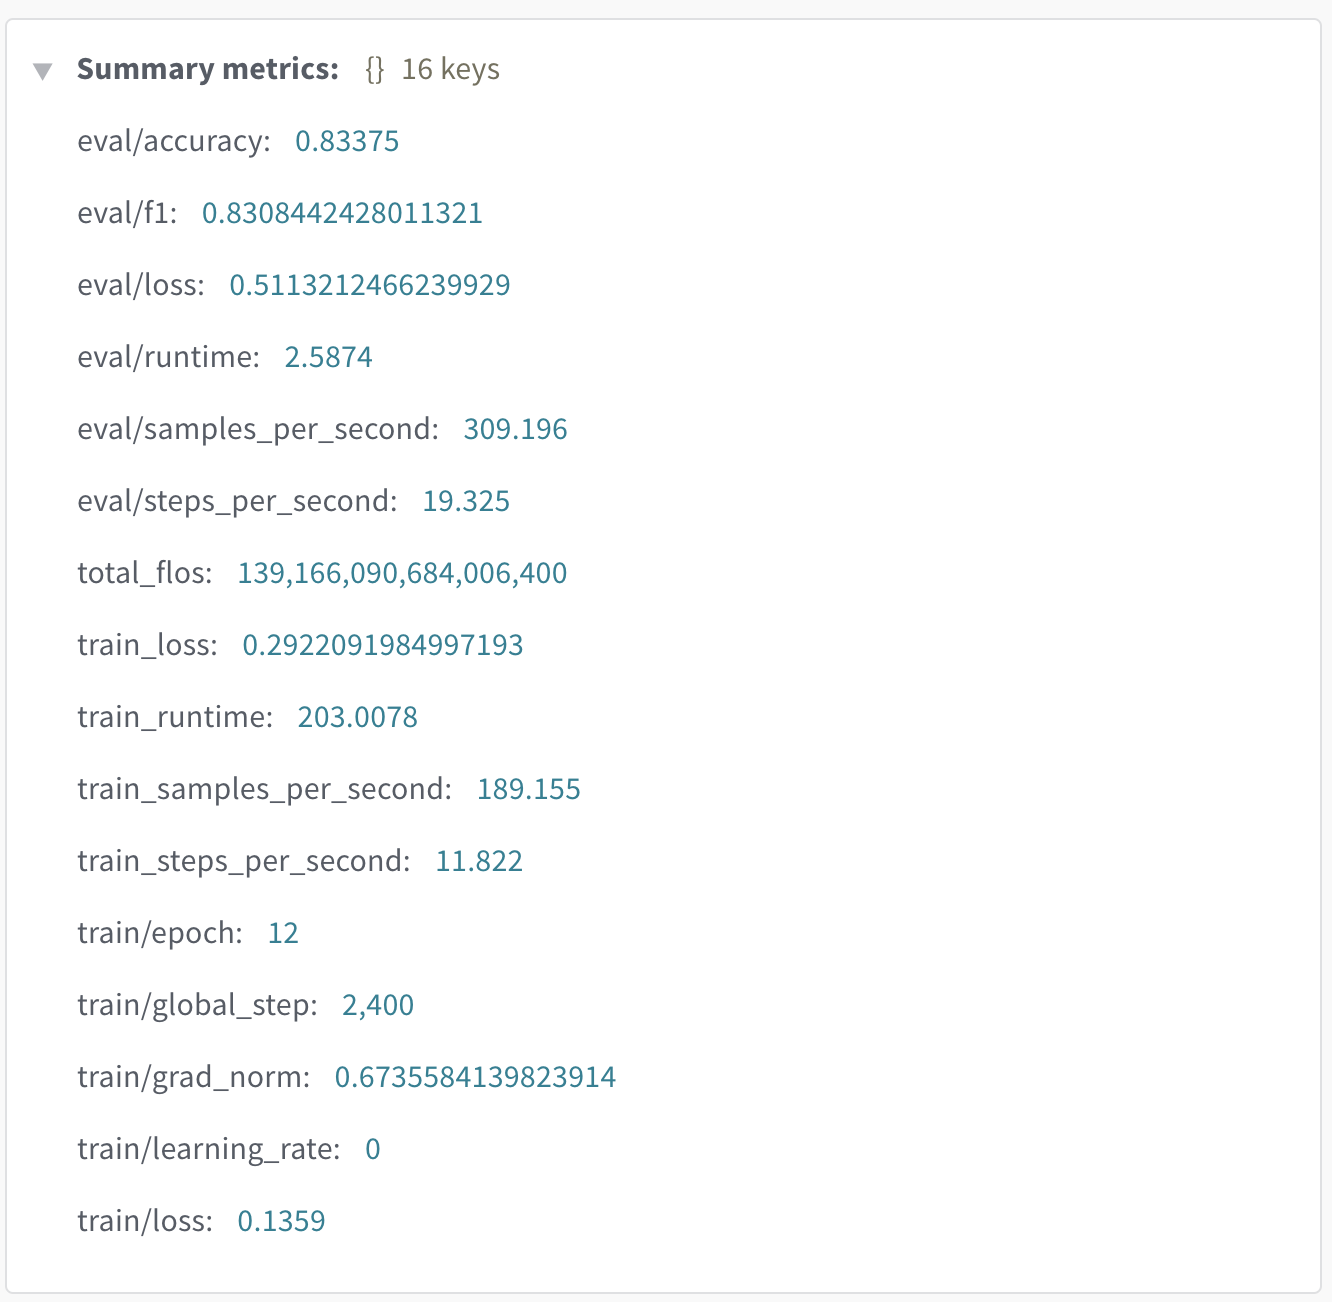
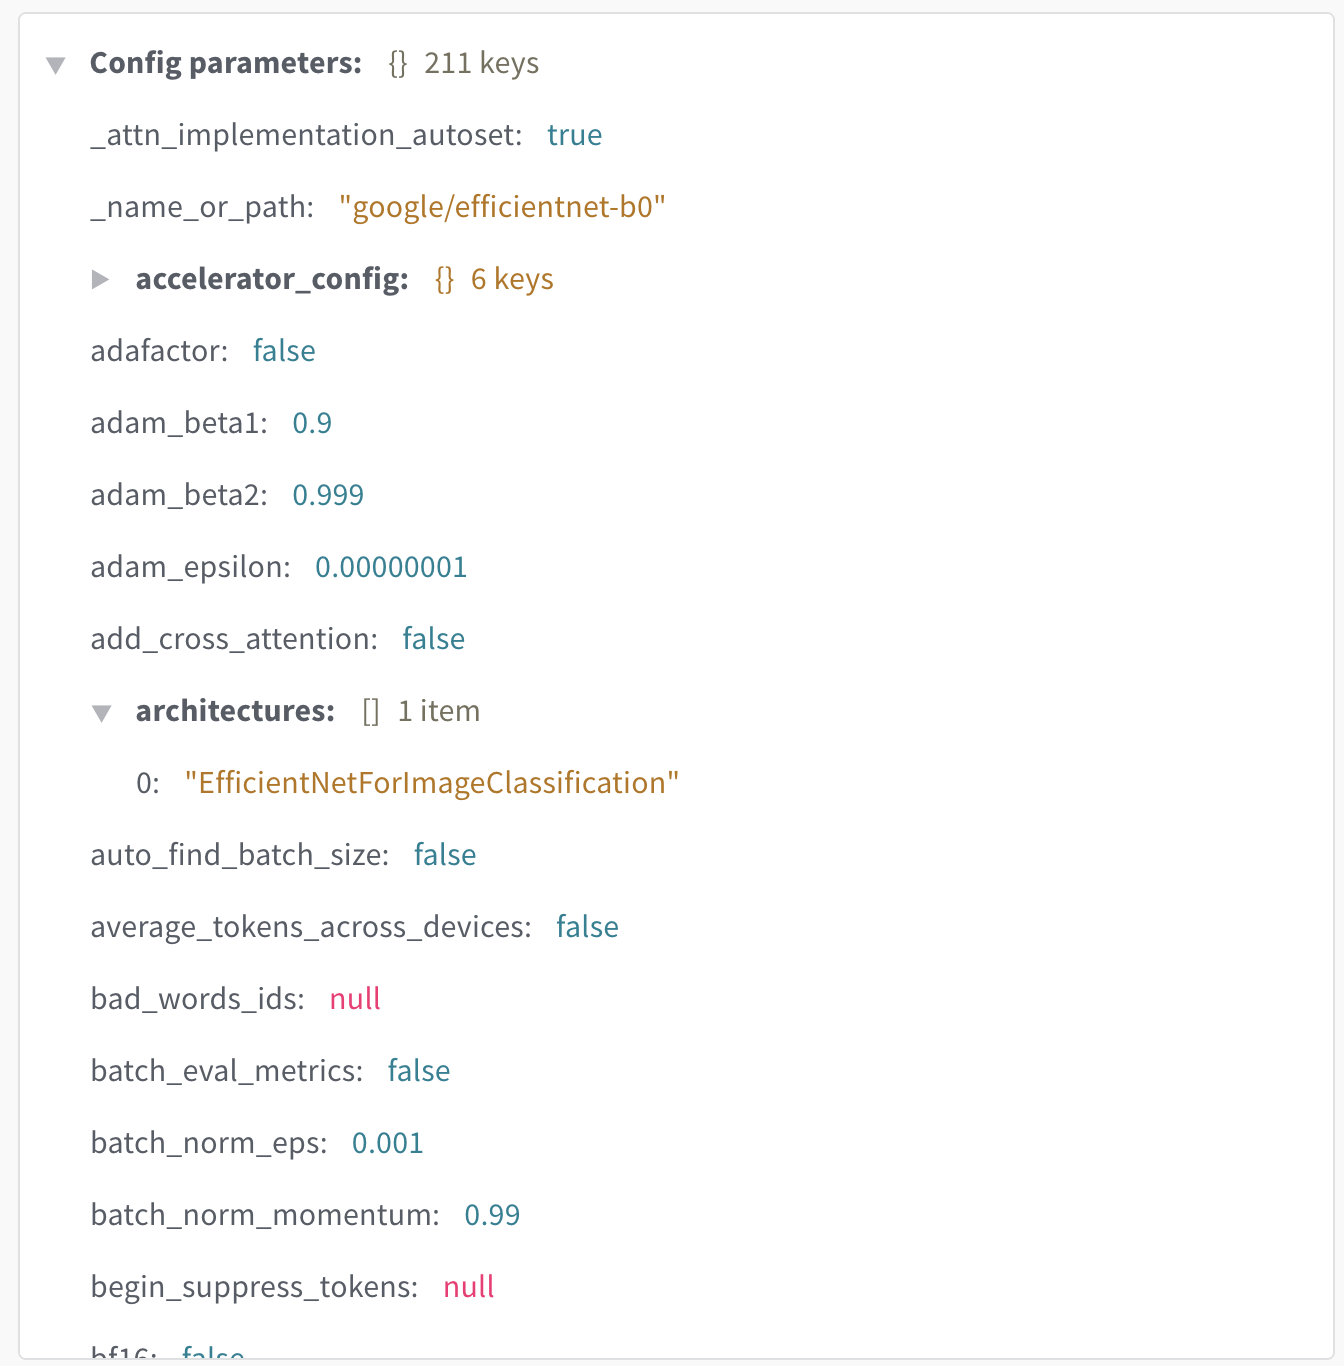

<p class='task' id='4'></p>

4\. Повторите решение задачи 3, настроив процедуру ранней остановки (используйте механизм callback для Trainer). Логика ранней остановки следующая: если метрика F1 не увеличивалась на валидационном множестве в течение 3 последних эпох, то процесс обучения останавливается.

- [ ] Проверено на семинаре

In [18]:
wandb.init(project='image-classification-project')

In [19]:
from transformers import EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=12,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_strategy='epoch',
    eval_strategy='epoch',
    logging_strategy='steps',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to='wandb',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.058600,0.528019,0.835000,0.832316
2,0.017600,0.558741,0.845000,0.844916
3,0.026100,0.648070,0.837500,0.835343
4,0.013100,0.769770,0.837500,0.834630
5,0.006200,0.721593,0.821250,0.821230


TrainOutput(global_step=1000, training_loss=0.05412472476065159, metrics={'train_runtime': 84.8217, 'train_samples_per_second': 452.714, 'train_steps_per_second': 28.295, 'total_flos': 5.7985871118336e+16, 'train_loss': 0.05412472476065159, 'epoch': 5.0})

In [ ]:
wandb.finish()

eval/accuracy,▅█▆▆▁
eval/f1,▄█▅▅▁
eval/loss,▁▂▄█▇
eval/runtime,▅▇▃▁█
eval/samples_per_second,▄▂▆█▁
eval/steps_per_second,▄▂▆█▁
train/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▃▃▁▄▂▆▂▅▂▁▂▅▃▁▃▆▁▂▁▁▁▁▃▄▁▁▁▂▁▁▁▅▁▁▁█▁▁▃▁
train/learning_rate,██▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▁▁▁
train/loss,▅▆▇▇▆█▃▅▅▂▅▃▅▂▂▂▃▁▄▃▂▂▂▁▂▃▂▃▄▂▂▂▁▃▄▂▂▁▂▂
